In [1]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing
from iads.recommandation import prediction

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, SlopeOne
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [2]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,Nombre d'avis,full_title,Note rectifiée,Note,Note Finkel,categories,Nombre d'avis rectifiés,description,titre,_id,...,editors,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,multi
0,19.0,Marvel United (2020),8.40,7.58,8.74,NaN,10.0,marvel united unir contre super vilain red sku...,Marvel United,marvel-united,...,CMON Limited,NaN,1-4,14-99,45.0,0,1,1,1,1
1,33.0,Mariposas (2020),7.29,7.39,7.68,NaN,17.0,annee printemps million papillon monarque quit...,Mariposas,mariposas,...,Gigamic,NaN,2-5,14-99,60.0,0,1,1,0,1


In [3]:
df_avis = pd.read_csv("../data/avis_clean.csv")
df_avis.head(2)

,comment,date_published,title_review,title,note,author,treated,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021,Voyages sur les ailes des papillons,Mariposas,8.0,Monsieur Guillaume,True,mariposas
1,Comment continuer après un mega hit ? Simpleme...,2020,le festival de Michoacan,Mariposas,7.0,morlockbob,True,mariposas


In [4]:
users = df_avis['author'].unique()
games = df_jeux['_id'].unique()
nombre_zeros = len(df_avis) / (len(users) * len(games))
print(nombre_zeros*100, "% des éléments sont non nuls")

0.07667376926719226 % des éléments sont non nuls


## Statistiques

In [5]:
nb_users = len(users)
nb_jeux = len(games)

print(f"Il y a {nb_users} utilisateurs et {nb_jeux} jeux")

Il y a 13623 utilisateurs et 16873 jeux


In [6]:
df_avis["note"].describe()

count    176243.000000
mean          7.478046
std           2.171968
min           0.000000
25%           6.000000
50%           8.000000
75%           9.300000
max          10.000000
Name: note, dtype: float64

<AxesSubplot:xlabel='note', ylabel='Density'>

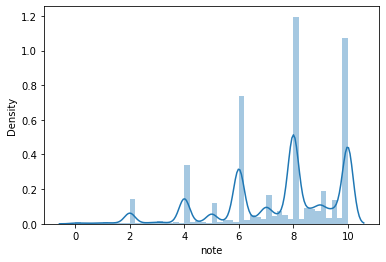

In [7]:
sns.distplot(df_avis["note"])   

Distribution par utilisateur

<AxesSubplot:xlabel='note', ylabel='Density'>

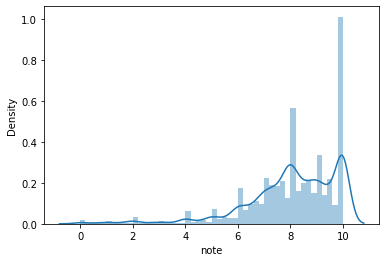

In [8]:
user_means = df_avis.groupby("author")["note"].mean()
sns.distplot(user_means)

Distribution par jeu

<AxesSubplot:xlabel='note', ylabel='Density'>

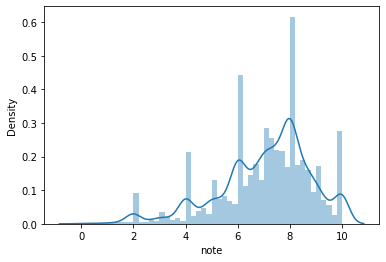

In [9]:
item_means = df_avis.groupby("title_id_jeu")["note"].mean()
sns.distplot(item_means)

Vérification que chaque author n'a donné qu'un seul avis pour un jeu donné : 

In [10]:
for i in df_avis.groupby(['author', 'title_id_jeu']):
    if len(i[1]) > 1:
        print("Duplicated author and title")
        break

Finalement il n'y a pas de doublons

## Collaborative filtering

In [11]:
nb_avis_min = 5

<AxesSubplot:xlabel='note', ylabel='Density'>

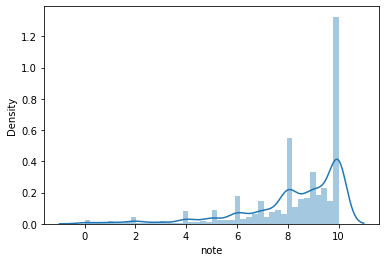

In [12]:
users, count_users = np.unique(df_avis["author"],return_counts=True)
g_users = df_avis.groupby("author")["note"].mean()
users_filtred = users[count_users < nb_avis_min]
sns.distplot(g_users[users_filtred])

In [13]:
index_df_filter = np.isin(df_avis["author"], users_filtred)

In [14]:
print("On a eliminer", 100 * (len(users) - len(users_filtred)) / len(users), "% des utilisateurs")
print("On a eliminer", 100 * index_df_filter.sum() / len(df_avis), "% des avis")

On a eliminer 34.51515818835792 % des utilisateurs
On a eliminer 8.461045261372083 % des avis


In [15]:
df_avis_filter = df_avis[index_df_filter][['author', 'title_id_jeu', 'note']]

In [16]:
train_ratings, test_ratings = train_test_split(df_avis_filter, test_size=0.2)

In [17]:
data = Dataset.load_from_df(train_ratings, Reader(rating_scale=(0, 10)))

### Baseline algorithm

In [18]:
bs_model = BaselineOnly()
bs_model.fit(data.build_full_trainset())

Estimating biases using als...


In [19]:
test_ratings["baseline_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(bs_model, u_item), axis=1)
test_ratings

,author,title_id_jeu,note,baseline_pred
44504,tassin,zombie-15,10.0,8.679033
89955,Alienor39,logik-ville,8.0,8.286588
70192,Nanana,smash-up,9.6,8.296405
129756,SeamSeam,tomahawk,8.0,7.963158
174062,TiDuSis,yams-yahtzee,9.2,7.744175
...,...,...,...,...
81297,Belgarion41,o-k-corral,10.0,8.016084
173455,le paladin,une-vie-de-chien,4.0,7.515688
39580,El Foko,blanc-manger-coco-1,8.6,7.052831
1915,Sir Arno,small-world-of-warcraft,8.0,7.880993


### SVD algorithm

Par défaut dans SVD n_factors (Z) est à 100 et n_epoch est à 20
On va chercher une valeur optimale pour les deux en utilisant GridSearchCV

{'n_factors': 50}


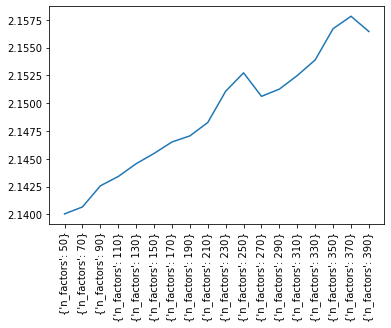

,author,title_id_jeu,note,baseline_pred,svd_pred
44504,tassin,zombie-15,10.0,8.679033,8.643086
89955,Alienor39,logik-ville,8.0,8.286588,8.337854
70192,Nanana,smash-up,9.6,8.296405,8.373634
129756,SeamSeam,tomahawk,8.0,7.963158,7.996275
174062,TiDuSis,yams-yahtzee,9.2,7.744175,7.690902
...,...,...,...,...,...
81297,Belgarion41,o-k-corral,10.0,8.016084,8.013417
173455,le paladin,une-vie-de-chien,4.0,7.515688,7.191909
39580,El Foko,blanc-manger-coco-1,8.6,7.052831,7.089574
1915,Sir Arno,small-world-of-warcraft,8.0,7.880993,7.775121


In [20]:
param_grid = {'n_factors':list(range(50, 401, 20))}

svd_model = prediction.gs_pred(data, SVD, param_grid)

test_ratings["svd_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(svd_model, u_item), axis=1)
test_ratings 

### KNN Basic

{'k': 5, 'verbose': False}


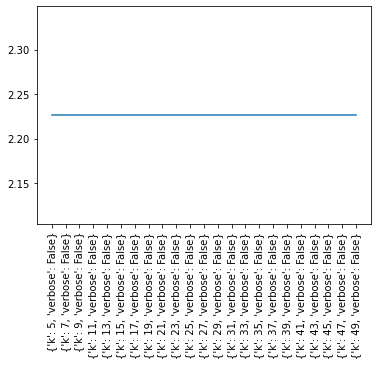

,author,title_id_jeu,note,baseline_pred,svd_pred,knnBasic_pred
44504,tassin,zombie-15,10.0,8.679033,8.643086,8.195876
89955,Alienor39,logik-ville,8.0,8.286588,8.337854,8.195876
70192,Nanana,smash-up,9.6,8.296405,8.373634,8.195876
129756,SeamSeam,tomahawk,8.0,7.963158,7.996275,8.195876
174062,TiDuSis,yams-yahtzee,9.2,7.744175,7.690902,8.195876
...,...,...,...,...,...,...
81297,Belgarion41,o-k-corral,10.0,8.016084,8.013417,8.195876
173455,le paladin,une-vie-de-chien,4.0,7.515688,7.191909,8.195876
39580,El Foko,blanc-manger-coco-1,8.6,7.052831,7.089574,8.195876
1915,Sir Arno,small-world-of-warcraft,8.0,7.880993,7.775121,8.195876


In [21]:
param_grid = {'k': list(range(5, 51, 2)), 'verbose': [False]}

knn_pred = prediction.gs_pred(data, KNNBasic, param_grid)

test_ratings["knnBasic_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(knn_pred, u_item), axis=1)
test_ratings 

### SlopeOne

In [22]:
slope_one_model = SlopeOne()
slope_one_model.fit(data.build_full_trainset())

In [24]:
test_ratings["slopeOne_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(slope_one_model, u_item), axis=1)
test_ratings 

,author,title_id_jeu,note,baseline_pred,svd_pred,knnBasic_pred,slopeOne_pred
44504,tassin,zombie-15,10.0,8.679033,8.643086,8.195876,10.000000
89955,Alienor39,logik-ville,8.0,8.286588,8.337854,8.195876,10.000000
70192,Nanana,smash-up,9.6,8.296405,8.373634,8.195876,8.250000
129756,SeamSeam,tomahawk,8.0,7.963158,7.996275,8.195876,10.000000
174062,TiDuSis,yams-yahtzee,9.2,7.744175,7.690902,8.195876,8.350000
...,...,...,...,...,...,...,...
81297,Belgarion41,o-k-corral,10.0,8.016084,8.013417,8.195876,8.195876
173455,le paladin,une-vie-de-chien,4.0,7.515688,7.191909,8.195876,4.000000
39580,El Foko,blanc-manger-coco-1,8.6,7.052831,7.089574,8.195876,10.000000
1915,Sir Arno,small-world-of-warcraft,8.0,7.880993,7.775121,8.195876,5.000000


### SVD ++

{'n_factors': 50}


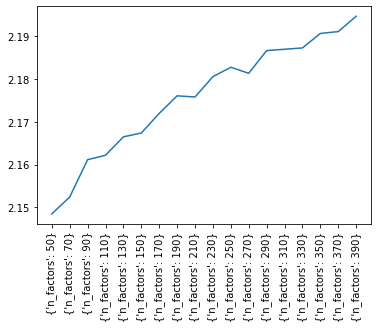

,author,title_id_jeu,note,baseline_pred,svd_pred,knnBasic_pred,slopeOne_pred,svdpp_pred
44504,tassin,zombie-15,10.0,8.679033,8.643086,8.195876,10.000000,8.418999
89955,Alienor39,logik-ville,8.0,8.286588,8.337854,8.195876,10.000000,8.440872
70192,Nanana,smash-up,9.6,8.296405,8.373634,8.195876,8.250000,8.123372
129756,SeamSeam,tomahawk,8.0,7.963158,7.996275,8.195876,10.000000,7.906459
174062,TiDuSis,yams-yahtzee,9.2,7.744175,7.690902,8.195876,8.350000,7.684373
...,...,...,...,...,...,...,...,...
81297,Belgarion41,o-k-corral,10.0,8.016084,8.013417,8.195876,8.195876,7.986905
173455,le paladin,une-vie-de-chien,4.0,7.515688,7.191909,8.195876,4.000000,7.035275
39580,El Foko,blanc-manger-coco-1,8.6,7.052831,7.089574,8.195876,10.000000,6.848949
1915,Sir Arno,small-world-of-warcraft,8.0,7.880993,7.775121,8.195876,5.000000,7.961850


In [25]:
param_grid = {'n_factors':list(range(50, 401, 20))}

svdpp_model = prediction.gs_pred(data, SVDpp, param_grid)

test_ratings["svdpp_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(svdpp_model, u_item), axis=1)
test_ratings 

### Meilleur algo au sens des MSE

In [28]:
def mse(predictions,truth):
    return ((predictions - truth)**2).mean()

In [29]:
results = {}

results["baseline"] = mse(test_ratings["baseline_pred"], test_ratings["note"])
results["svd"] = mse(test_ratings["svd_pred"], test_ratings["note"])
results["knnBasic"] = mse(test_ratings["knnBasic_pred"], test_ratings["note"])
results["slopeOne"] = mse(test_ratings["slopeOne_pred"], test_ratings["note"])
results["svdpp"] = mse(test_ratings["svdpp_pred"], test_ratings["note"])

results

{'baseline': 5.043114374884152,
 'svd': 5.017238886403862,
 'knnBasic': 5.426139275229268,
 'slopeOne': 6.389332709833077,
 'svdpp': 5.018897637662299}

In [35]:
algo_min = min(results, key=results.get)
print("L'algorithme qui minimise la mse est :", algo_min, "avec une valeur de", results[algo_min])

L'algorithme qui minimise la mse est : svd avec une valeur de 5.017238886403862


## Création d'un systeme de recommandation pour un utlisateur :

In [62]:
def basic_recommand_games(model, user, games, df, nb_games=3):
    scores = []
    
    user_games = list(df[df["author"] == user]["title_id_jeu"])
    
    for game in games:
        if game in user_games:
            scores.append(0)
            continue
        
        prediction = model.predict(user, game)
        scores.append(prediction.est)
    
    scores = np.array(scores)
    i_sort = np.argsort(-scores)
    return games[i_sort[:nb_games]]
        

In [63]:
basic_recommand_games(svd_model, "prunelles", games, df_avis)

array(['yamatai', 'android-netrunner-das-kartenspiel',
       'conflict-of-heroes-le-reveil-de-l-ours'], dtype=object)

In [65]:
basic_recommand_games(bs_model, "prunelles", games, df_avis)

array(['conflict-of-heroes-le-reveil-de-l-ours', 'yamatai',
       'android-netrunner-das-kartenspiel'], dtype=object)

In [66]:
basic_recommand_games(svdpp_model, "prunelles", games, df_avis)

array(['porta-nigra-0', 'conflict-of-heroes-le-reveil-de-l-ours',
       'yamatai'], dtype=object)

In [67]:
basic_recommand_games(slope_one_model, "prunelles", games, df_avis)

array(['marvel-united', 'star-fist', 'hide-and-seek-pirates'],
      dtype=object)

In [68]:
basic_recommand_games(knn_pred, "prunelles", games, df_avis)

array(['marvel-united', 'star-fist', 'hide-and-seek-pirates'],
      dtype=object)